In [1]:
import pandas as pd
import yfinance as yf
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import gurobipy as gp
from gurobipy import GRB

In [2]:
# function to fetch data from yahoo finance for 1 year
def FetchData(Tickers,Period="1y",Interval='1d',Start=None,End=None,Group_by='column',Column='Adj Close'):

    """
    Return the data for tickers
    Parameters:
        tickers : str, list             List of tickers to download
        period : str             Valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max Either Use period parameter or use start and end
        interval : str             Valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo Intraday data cannot extend last 60 days
        start: str             Download start date string (YYYY-MM-DD) or _datetime. Default is 1900-01-01
        end: str             Download end date string (YYYY-MM-DD) or _datetime. Default is now
        group_by : str             Group by 'ticker' or 'column' (default)
    """
    StockData = yf.download(Tickers,start=Start,end=End,period=Period,interval=Interval)

    if Column!=None:
        SelectedData = StockData[Column]
    else:
        SelectedData = StockData

    return(SelectedData)



In [3]:
def Calculation(Data_Selected):
    ''' calculate the mean percent change and covariance for the stocks. Then annualized the value and return. '''
   
    Stock_pct_change = Data_Selected.pct_change()
    Mean_Change = Stock_pct_change.mean()*252
    Change_Cov = Stock_pct_change.cov()*252
    
    return(Mean_Change,Change_Cov)

In [4]:
def ComparitiveDisplay(StockData):
    # Display the growth of stocks by setting starting price to 100
    # The graph is displayed then
    ticker_list=StockData.columns
    temp_df = pd.DataFrame()
    for i in ticker_list:
        temp_df[i]=(StockData[i]/StockData[i][0])*100
    
        
    plt.figure(figsize=(20,5))
    sns.lineplot(data=temp_df)

    return()
    

In [50]:
# Selection of the Stocks for optimization
Tickers_List_small = ['GE','T','PG','AMZN','CL','CVS']
StockPrice = FetchData(Tickers_List_small)
Stock_Mean_Change, Stock_Cov_Change = Calculation(StockPrice)

[*********************100%***********************]  6 of 6 completed


()

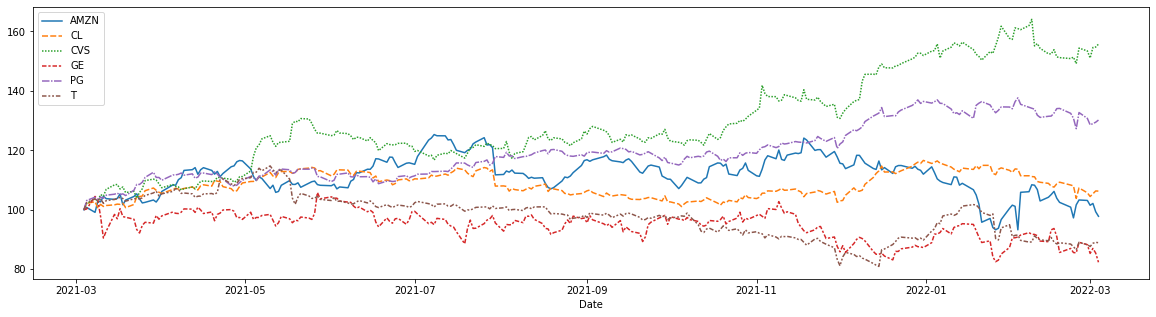

In [51]:
ComparitiveDisplay(StockPrice)

In [52]:
def Performance(weights, mean_change, change_cov):
    
    portfolio_return = np.dot(weights, mean_change)
    porfolio_std = np.dot(np.dot(change_cov, weights),weights)
    return(portfolio_return,porfolio_std)

In [53]:
Portfolio_Weights = np.ones(6)/6
Performance(Portfolio_Weights, Stock_Mean_Change, Stock_Cov_Change)

(0.09992490446203105, 0.01626245570496367)

In [56]:
def Efficient_Frontier_Montcarlo(Tickers,no_of_iter):
    stockdata = FetchData(Tickers)
    stock_mean_change, stock_cov_change = Calculation(stockdata)
    temp_data = pd.DataFrame(columns=['Return','Std_dev'])
    for i in range(no_of_iter):
        weights=np.random.random(6)
        portfolio_weights = weights/weights.sum()
        port_ret, port_std = Performance(portfolio_weights,stock_mean_change,stock_cov_change)
        temp1=pd.DataFrame([[port_ret,port_std]],columns=['Return','Std_dev'])
        temp_data = pd.concat([temp_data,temp1],ignore_index=True)
    plt.figure(figsize=(20,5))
    sns.scatterplot(data=temp_data,y='Return',x='Std_dev')
    return()

[*********************100%***********************]  6 of 6 completed


()

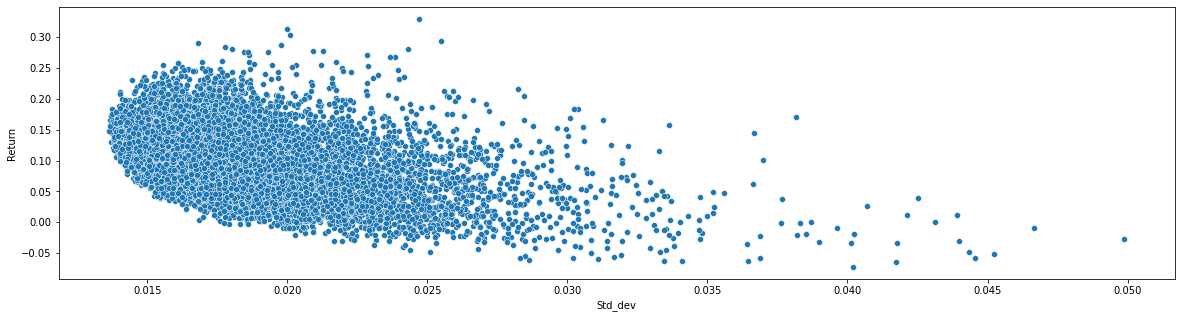

In [58]:
Efficient_Frontier_Montcarlo(Tickers_List_small,10000)

In [11]:
def SharpeRatio(Tickers,weights,RiskFreeRate):
    stockdata = FetchData(Tickers)
    stock_mean_change, stock_cov_change = Calculation(stockdata)
    port_ret, port_std = Performance(weights,stock_mean_change,stock_cov_change)

    return((port_ret-RiskFreeRate)/port_std)
    


In [59]:
SharpeRatio(Tickers_List_small, Portfolio_Weights, 0.025)

[*********************100%***********************]  6 of 6 completed


4.629885653407503

In [60]:
def OptimizedPortfolio(Tickers, Expectedreturn):

    stock_data = FetchData(Tickers)
    stock_mean_ret, stock_covariance = Calculation(stock_data)

    

    m = gp.Model('PortFolio optimization')

    weight = m.addMVar(len(Tickers))

    m.addConstr(weight.sum() == 1)
    port_std = weight @ stock_covariance.values @ weight
    port_ret = weight @ stock_mean_ret.values
    m.addConstr(port_ret == Expectedreturn)
    #m.addConstr(port_ret <= weight @ stock_mean_ret.values)

    
    m.setObjective(port_std, GRB.MINIMIZE)

    m.update()
    m.optimize()
    print(port_ret.getValue()[0])

    
    return(m.X)


In [14]:
Tickers_List = ['BRK-A', 'AAPL', 'MSFT', 'JPM', 'GOOG', 'BAC', 'INTC', 'WFC',
          'C', 'VZ', 'FB', 'PFE', 'JNJ', 'WMT', 'XOM',
          'FNMA', 'T', 'UNH', 'CMCSA', 'V' ]

In [28]:
def Efficient_Frontier_QP(Tickers,Resolution=4):

    stock_data = FetchData(Tickers)
    stock_mean_ret, stock_covariance = Calculation(stock_data)
    MinRet = stock_mean_ret.values.min()
    MaxRet = stock_mean_ret.values.max()
    m = gp.Model('PortFolio optimization')
    weight = m.addMVar(len(Tickers))
    m.addConstr(weight.sum() == 1)
    port_std = weight @ stock_covariance.values @ weight
    port_ret = weight @ stock_mean_ret.values
    returnrate = MinRet
    target = m.addConstr(port_ret == returnrate,'target')
    Frontier = pd.DataFrame([],columns=['Return','Std','Result'])
    for i in np.linspace(MinRet,MaxRet,Resolution):
        
        target[0].rhs = i
        #m.addConstr(port_ret <= weight @ stock_mean_ret.values)
        m.setObjective(port_std, GRB.MINIMIZE)
        m.update()
        m.optimize()
        temp = pd.DataFrame([[i,m.ObjVal,m.X]],columns=['Return','Std','Result'])

        Frontier = pd.concat([Frontier,temp],ignore_index=True)
    
    return(Frontier)

In [30]:
def DisplayEffFrontier(frontier_Cal):

    plt.figure(figsize=(20,5))

    a_plot=sns.scatterplot(data=frontier_Cal,x='Std',y='Return')
    a_plot.set(xlim=(0, frontier_Cal['Std'].max()))
    a_plot.set(ylim=(frontier_Cal['Return'].min(), frontier_Cal['Return'].max()+0.1))
    return()

[*********************100%***********************]  20 of 20 completed
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2 rows, 20 columns and 40 nonzeros
Model fingerprint: 0xb36d4eb4
Model has 210 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-02, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-05, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+00]
Presolve time: 0.00s
Presolved: 2 rows, 20 columns, 40 nonzeros
Presolved model has 210 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 19
 AA' NZ     : 2.100e+02
 Factor NZ  : 2.310e+02
 Factor Ops : 3.311e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.64392817e+05 -1.64392817e+05  1.27e+04 5.50e-

()

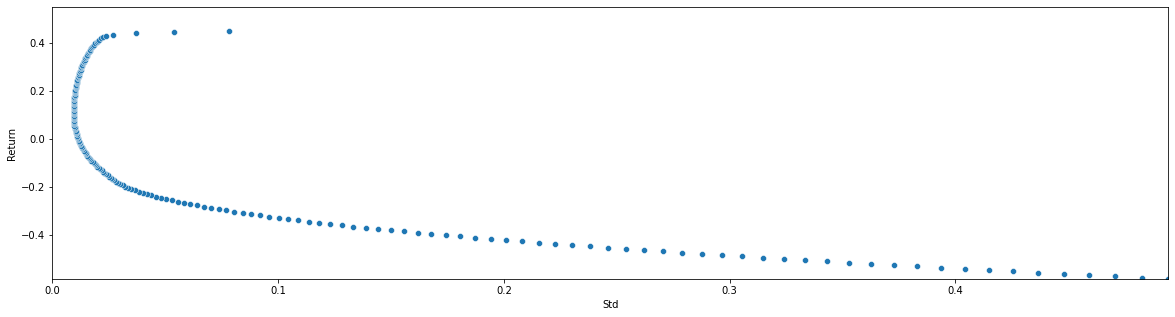

In [31]:
Eff_Portfolio = Efficient_Frontier_QP(Tickers_List,200)
DisplayEffFrontier(Eff_Portfolio)

In [33]:
def EfficientVsRiskFree(Portfolio_Data,RiskFreeRate):
    temp=0
    for i in range(len(Portfolio_Data)):
        Port_ret = Portfolio_Data.loc[i,'Return']
        Std_ret = Portfolio_Data.loc[i,'Std']
        slope = (Port_ret - RiskFreeRate)/(Std_ret - 0)
        if slope> temp:
            temp=max(temp,slope)
            b=Portfolio_Data.loc[i,:]
    return(b)


In [36]:
BestPortfolio = EfficientVsRiskFree(Eff_Portfolio,0.025)

In [39]:
print(BestPortfolio.Result)

[0.05202309380798463, 6.536707895200134e-10, 0.15488480826011228, 2.700993837628188e-10, 3.39469955080544e-10, 2.0482714540687236e-10, 2.7070169610686e-10, 1.81638910153357e-07, 2.690639106345312e-10, 3.164542423870044e-05, 3.114497858843644e-10, 0.11786471238374671, 0.1410539916375134, 4.595168780103815e-10, 0.18908980055444738, 3.025409835225907e-10, 0.07736443921573517, 1.0742671652046866e-09, 0.13437678524791996, 0.13331053767421236]


In [61]:
def OptimizedSelectPortfolio(Tickers, Expectedreturn, NoOfSelection):

    stock_data = FetchData(Tickers)
    stock_mean_ret, stock_covariance = Calculation(stock_data)

    

    m = gp.Model('PortFolio optimization')

    weight = m.addMVar(len(Tickers))
    Stock_Selected = m.addMVar(len(Tickers),vtype=GRB.BINARY)

    for i in range(len(Tickers)):
        m.addConstr(Stock_Selected[i]>=weight[i])

    m.addConstr(Stock_Selected.sum() <= NoOfSelection)
    m.addConstr(weight.sum() == 1)
    port_std = weight @ stock_covariance.values @ weight
    port_ret = weight @ stock_mean_ret.values
    m.addConstr(port_ret == Expectedreturn)
    #m.addConstr(port_ret <= weight @ stock_mean_ret.values)

    
    m.setObjective(port_std, GRB.MINIMIZE)

    m.update()
    m.optimize()
    print(port_ret.getValue()[0])

    
    return(m.X)

In [71]:
returndf = OptimizedSelectPortfolio(Tickers_List,0.30,5)

[*********************100%***********************]  20 of 20 completed
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 40 columns and 100 nonzeros
Model fingerprint: 0x0d2262d2
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-04, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 5e+00]
Presolve time: 0.00s
Presolved: 23 rows, 40 columns, 99 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Found heuristic solution: objective 0.0322462
Found heuristic solution: objective 0.0279064

Root relaxation: objective 1.323642e-02, 27 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Wor

In [109]:
def Efficient_Select_Frontier_QP(Tickers,NoOfSelection,Resolution=4):

    stock_data = FetchData(Tickers)
    stock_mean_ret, stock_covariance = Calculation(stock_data)
    MinRet = stock_mean_ret.values.min()
    MaxRet = stock_mean_ret.values.max()
    m = gp.Model('PortFolio optimization')
    weight = m.addMVar(len(Tickers))
    Stock_Selected = m.addMVar(len(Tickers),vtype=GRB.BINARY)

    for i in range(len(Tickers)):
        m.addConstr(Stock_Selected[i]>=weight[i])

    m.addConstr(Stock_Selected.sum() <= NoOfSelection)
    m.addConstr(weight.sum() == 1)
    port_std = weight @ stock_covariance.values @ weight
    port_ret = weight @ stock_mean_ret.values
    returnrate = MinRet
    target = m.addConstr(port_ret == returnrate,'target')
    Frontier = pd.DataFrame([],columns=['Return','Std','Result'])
    for i in np.linspace(MinRet,MaxRet,Resolution):
        
        target[0].rhs = i
        #m.addConstr(port_ret <= weight @ stock_mean_ret.values)
        m.setObjective(port_std, GRB.MINIMIZE)
        m.update()
        m.optimize()
        t2=weight.x
        temp = pd.DataFrame([[i,m.ObjVal,t2]],columns=['Return','Std','Result'])

        Frontier = pd.concat([Frontier,temp],ignore_index=True)
    
    return(Frontier)

In [110]:
returndf = Efficient_Select_Frontier_QP(Tickers_List,5,100)

[*********************100%***********************]  20 of 20 completed
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 40 columns and 100 nonzeros
Model fingerprint: 0x99f4aca7
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-04, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-01, 5e+00]
Presolve removed 4 rows and 7 columns
Presolve time: 0.00s
Presolved: 19 rows, 33 columns, 81 nonzeros
Presolved model has 153 quadratic objective terms
Variable types: 17 continuous, 16 integer (16 binary)
Found heuristic solution: objective 0.4964518

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.496452 

Optimal solution

In [111]:
returndf

,Return,Std,Result
0,-0.586209,0.496452,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
1,-0.576029,0.472534,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.025518841729122665..."
2,-0.565848,0.449429,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.05103768345824555,..."
3,-0.555667,0.427137,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.07655652518736822,..."
4,-0.545486,0.405658,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.10207536691649122,..."
...,...,...,...
95,0.38097,0.018905,"[0.14749439310047843, 0.0, 0.101972157740128, ..."
96,0.391151,0.020078,"[0.14644111493301956, 0.0, 0.03485048454242823..."
97,0.401332,0.021691,"[0.08388003371402059, 0.0, 0.0, 0.0, 0.0, 0.0,..."
98,0.411513,0.02662,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


()

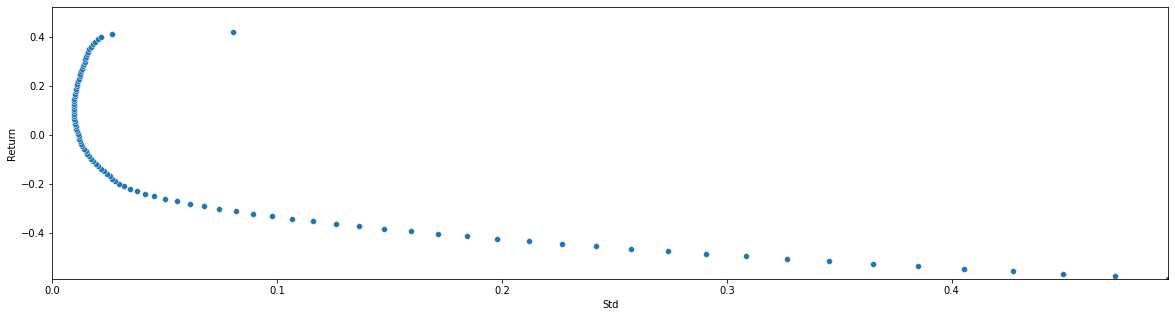

In [114]:
DisplayEffFrontier(returndf)

In [115]:
EfficientVsRiskFree(returndf,0.025)

Return                                             0.340247
Std                                                0.015854
Result    [0.0, 0.0, 0.27792442346414886, 0.0, 0.0, 0.0,...
Name: 91, dtype: object

In [116]:
EfficientVsRiskFree(returndf,0.025).Result

array([0.        , 0.        , 0.27792442, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.17319656, 0.17010404, 0.        , 0.24082649,
       0.        , 0.        , 0.        , 0.        , 0.13794848])

In [170]:
def Efficient_Select_Frontier_QP_Shift(ExistingPortfolio, Tickers, Margin=0.5, TimePeriod='1y',StartDate=None ,NoOfSelection=5 ,Resolution=4):

    stock_data = FetchData(Tickers,Period=TimePeriod,Start=StartDate)
    stock_mean_ret, stock_covariance = Calculation(stock_data)
    MinRet = stock_mean_ret.values.min()
    MaxRet = stock_mean_ret.values.max()
    m = gp.Model('PortFolio optimization')
    weight = m.addMVar(len(Tickers))
    Stock_Selected = m.addMVar(len(Tickers),vtype=GRB.BINARY)

    for i in range(len(Tickers)):
        m.addConstr(weight[i]>=ExistingPortfolio[i])
        m.addConstr(Stock_Selected[i]>=weight[i])
        
        #print(ExistingPortfolio[i]-Margin,ExistingPortfolio[i]+Margin)
        #m.addConstr(weight[i]>=ExistingPortfolio[i]-Margin)
        #m.addConstr(weight[i]<=ExistingPortfolio[i]+Margin)

    m.addConstr(Stock_Selected.sum() <= NoOfSelection)
    m.addConstr(weight.sum() == 1)
    port_std = weight @ stock_covariance.values @ weight
    port_ret = weight @ stock_mean_ret.values
    returnrate = MinRet
    target = m.addConstr(port_ret == returnrate,'target')
    Frontier = pd.DataFrame([],columns=['Return','Std','Result'])
    for i in np.linspace(MinRet,MaxRet,Resolution):
        
        target[0].rhs = i
        #m.addConstr(port_ret <= weight @ stock_mean_ret.values)
        m.setObjective(port_std, GRB.MINIMIZE)
        m.update()
        m.optimize()
        t2=weight.x
        temp = pd.DataFrame([[i,m.ObjVal,t2]],columns=['Return','Std','Result'])

        Frontier = pd.concat([Frontier,temp],ignore_index=True)
    
    return(Frontier)

In [147]:
def Efficient_Select_Frontier_QP_Time(Tickers, TimePeriod='1y',StartDate=None ,NoOfSelection=5 ,Resolution=4):

    stock_data = FetchData(Tickers,Period=TimePeriod,Start=StartDate)
    stock_mean_ret, stock_covariance = Calculation(stock_data)
    MinRet = stock_mean_ret.values.min()
    MaxRet = stock_mean_ret.values.max()
    m = gp.Model('PortFolio optimization')
    weight = m.addMVar(len(Tickers))
    Stock_Selected = m.addMVar(len(Tickers),vtype=GRB.BINARY)

    for i in range(len(Tickers)):
        m.addConstr(Stock_Selected[i]>=weight[i])


    m.addConstr(Stock_Selected.sum() <= NoOfSelection)
    m.addConstr(weight.sum() == 1)
    port_std = weight @ stock_covariance.values @ weight
    port_ret = weight @ stock_mean_ret.values
    returnrate = MinRet
    target = m.addConstr(port_ret == returnrate,'target')
    Frontier = pd.DataFrame([],columns=['Return','Std','Result'])
    for i in np.linspace(MinRet,MaxRet,Resolution):
        
        target[0].rhs = i
        #m.addConstr(port_ret <= weight @ stock_mean_ret.values)
        m.setObjective(port_std, GRB.MINIMIZE)
        m.update()
        m.optimize()
        t2=weight.x
        temp = pd.DataFrame([[i,m.ObjVal,t2]],columns=['Return','Std','Result'])

        Frontier = pd.concat([Frontier,temp],ignore_index=True)
    
    return(Frontier)

In [139]:
Resultdf = Efficient_Select_Frontier_QP_Time(Tickers_List,'1y',StartDate='2020-01-01', NoOfSelection=5,Resolution=200)

[*********************100%***********************]  20 of 20 completed
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 40 columns and 100 nonzeros
Model fingerprint: 0xaff8623d
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [8e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-01, 5e+00]
Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 22 rows, 39 columns, 96 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 19 integer (19 binary)
Found heuristic solution: objective 0.5050259

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.505026 

Optimal solution

In [144]:
CurrentPortfolio = EfficientVsRiskFree(Resultdf,0.025).Result

In [145]:
CurrentPortfolio

array([0.16874472, 0.        , 0.22653051, 0.        , 0.        ,
       0.        , 0.        , 0.24399709, 0.        , 0.        ,
       0.        , 0.        , 0.17265355, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.18807413, 0.        ])

In [171]:
Efficient_Select_Frontier_QP_Shift(np.zeros(20),Tickers_List,TimePeriod='1y',StartDate='2020-01-01', NoOfSelection=20, Resolution=200)

[*********************100%***********************]  20 of 20 completed
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 43 rows, 40 columns and 120 nonzeros
Model fingerprint: 0xaba9d924
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [8e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-01, 1e+01]
Presolve removed 21 rows and 1 columns
Presolve time: 0.00s
Presolved: 22 rows, 39 columns, 96 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 19 integer (19 binary)
Found heuristic solution: objective 0.5050259

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.505026 

Optimal solutio

,Return,Std,Result
0,-0.377945,0.505026,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
1,-0.37382,0.491171,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9844865333673..."
2,-0.369696,0.477546,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9689730667346..."
3,-0.365571,0.464153,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9534596001019..."
4,-0.361446,0.450989,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9379461334693..."
...,...,...,...
195,0.426338,0.116669,"[0.7879513835302672, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
196,0.430463,0.120904,"[0.8409635376477007, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
197,0.434587,0.125559,"[0.8939756917651343, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
198,0.438712,0.130634,"[0.9469878458825665, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
